<a href="https://colab.research.google.com/github/YoooonaLee/machine_learning/blob/main/SVM__%EC%95%84%EC%9D%B4%EB%A6%AC%EC%8A%A4_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D


## C값을 조정해서 hard margin일때와 soft margin일 때 비교

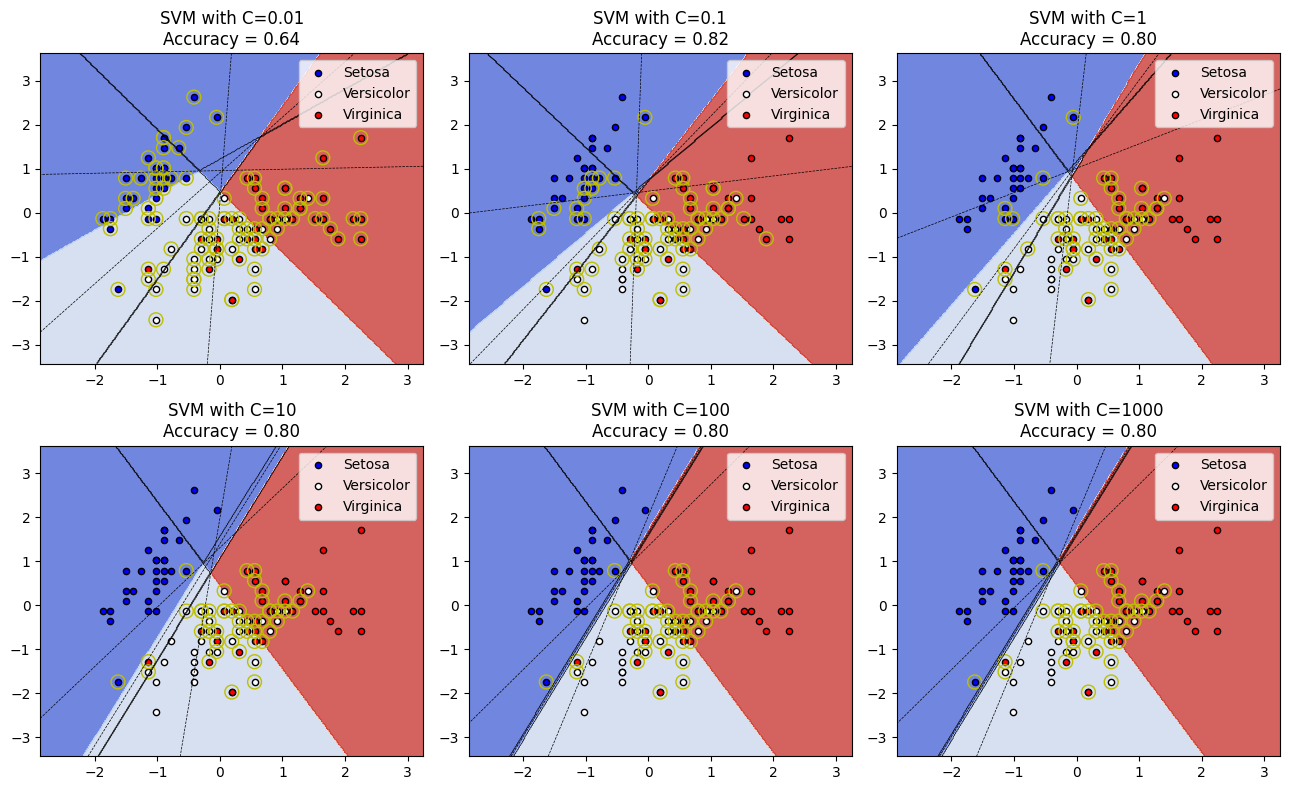

In [ ]:

from sklearn.svm import SVC

# 데이터 로드 및 준비
iris = datasets.load_iris()
X = iris.data[:, :2]  # 첫 두 개의 피처 사용
y = iris.target

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# C 값 배열 설정
C_values = [0.01, 0.1, 1, 10, 100, 1000] #⭐
rows = (len(C_values) + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(13, rows * 4))

# 서브플롯 평탄화
axes = axes.ravel()

# 클래스별 색상 정의
class_names = ['Setosa', 'Versicolor', 'Virginica']
colors = ['b', 'w', 'r']

for i, C in enumerate(C_values):
    # SVM 모델 생성 및 훈련 (OvR 방식 사용)
    model = SVC(kernel='linear', C=C, decision_function_shape='ovr') #⭐ svc모델 내부적으로 ovr방식으로 클래스를 선택해주는 로직이 있음.
    model.fit(X_train, y_train)

    # 결정 경계 그리기
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

    # 각 포인트에 대한 클래스 예측 (OvR 방식에서 최종 클래스 선택)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) #⭐
    Z = Z.reshape(xx.shape)

    # 시각화
    ax = axes[i]
    # 결정 경계 시각화
    contour = ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

    # 각 클래스의 결정 함수 계산 후 마진 시각화 #⭐
    if model.decision_function(np.c_[xx.ravel(), yy.ravel()]).ndim > 1:
        for j in range(model.decision_function(np.c_[xx.ravel(), yy.ravel()]).shape[1]): #shape[1]은 클래스의 수
            Z_margin = model.decision_function(np.c_[xx.ravel(), yy.ravel()])[:, j].reshape(xx.shape)
            ax.contour(xx, yy, Z_margin, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k', linewidths=0.5) #⭐0클래스가 실제 결정경계 -1,1은 마진경계
    else:
        Z_margin = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        ax.contour(xx, yy, Z_margin, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k', linewidths=0.5)

    # 서포트 벡터 및 학습 데이터 시각화
    for j, color in zip(np.unique(y_train), colors):
        ax.scatter(X_train[y_train == j, 0], X_train[y_train == j, 1], c=color, edgecolors='k', s=20, label=class_names[j])

    # 범례 추가
    ax.legend()

    ax.set_title(f'SVM with C={C}\nAccuracy = {accuracy_score(y_test, model.predict(X_test)):.2f}')

    # 서포트 벡터 표시
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='y')

plt.tight_layout()
plt.show()


##📑 결국 아무리 잘 분류해도? 2차원상에서 데이터를 선형분류하는 것은 한계가 있음. 특히 빨강색 흰색 데이터 포인터들..
##=> 커널개념 도입


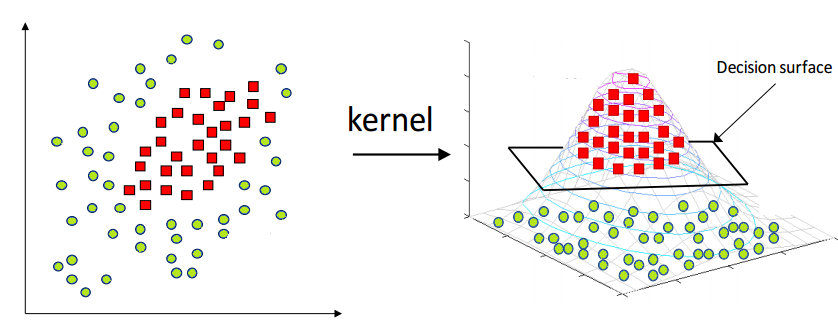

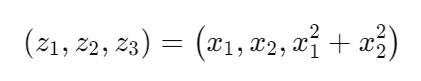



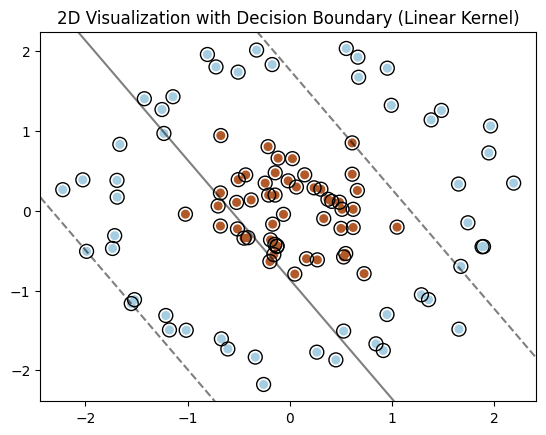

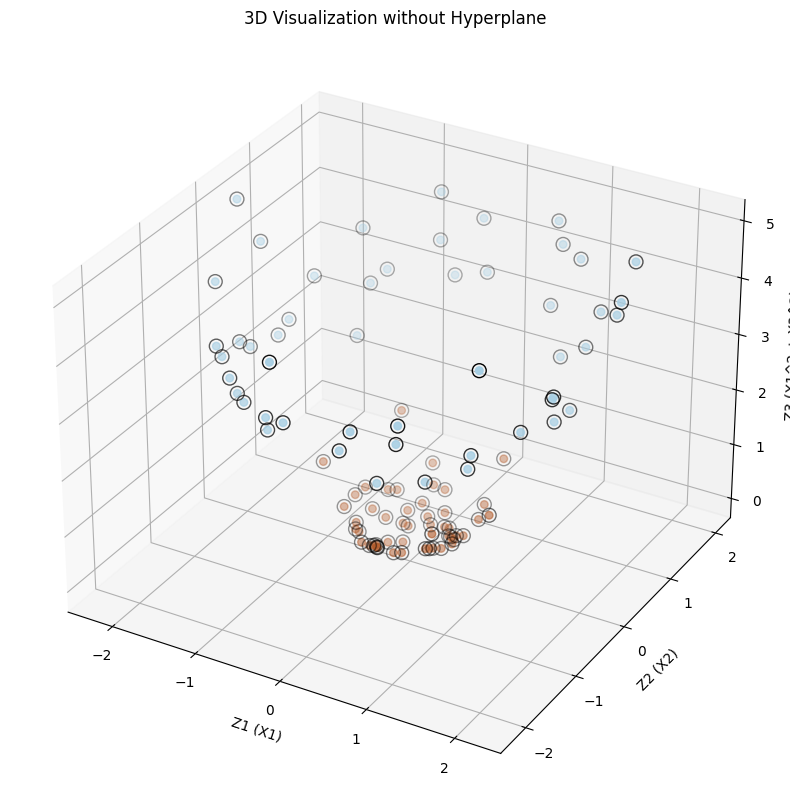

In [ ]:


#  비선형 데이터를 생성
X, y = datasets.make_circles(n_samples=100, factor=0.3, noise=0.1, random_state=42) #factor는 두 원사이간격 조절

#  데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  SVM 모델 정의 (선형 커널 사용)
svm_linear = SVC(kernel='linear', C=1)  # 선형 커널 사용
svm_linear.fit(X_scaled, y)

#  2차원 시각화 (커널을 통한 결정 경계 반영)
def plot_svc_decision_boundary(svm, X, y, title):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    # 메쉬 그리드 생성
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))

    # 결정 경계 그리기
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 결정 경계 및 마진 경계 표시
    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # 서포트 벡터 표시
    ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=100, #⭐
               linewidth=1, facecolors='none', edgecolors='k')
    plt.title(title)
    plt.show()

#  2차원 결정 경계 시각화
plot_svc_decision_boundary(svm_linear, X_scaled, y, "2D Visualization with Decision Boundary (Linear Kernel)")

#  커널 변환: z3 = x1^2 + x2^2
Z1 = X_scaled[:, 0]
Z2 = X_scaled[:, 1]
Z3 = Z1**2 + Z2**2

#  3D 시각화 (평면 없이 서포트 벡터만 표시)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 서포트 벡터 표시
ax.scatter(Z1, Z2, Z3, c=y, cmap=plt.cm.Paired, s=30)

# 서포트 벡터 강조 표시
ax.scatter(svm_linear.support_vectors_[:, 0], svm_linear.support_vectors_[:, 1],
           svm_linear.support_vectors_[:, 0]**2 + svm_linear.support_vectors_[:, 1]**2,
           s=100, facecolors='none', edgecolors='k')

# 축 및 제목 설정
ax.set_xlabel('Z1 (X1)')
ax.set_ylabel('Z2 (X2)')
ax.set_zlabel('Z3 (X1^2 + X2^2)')
ax.set_title("3D Visualization without Hyperplane")

plt.show()


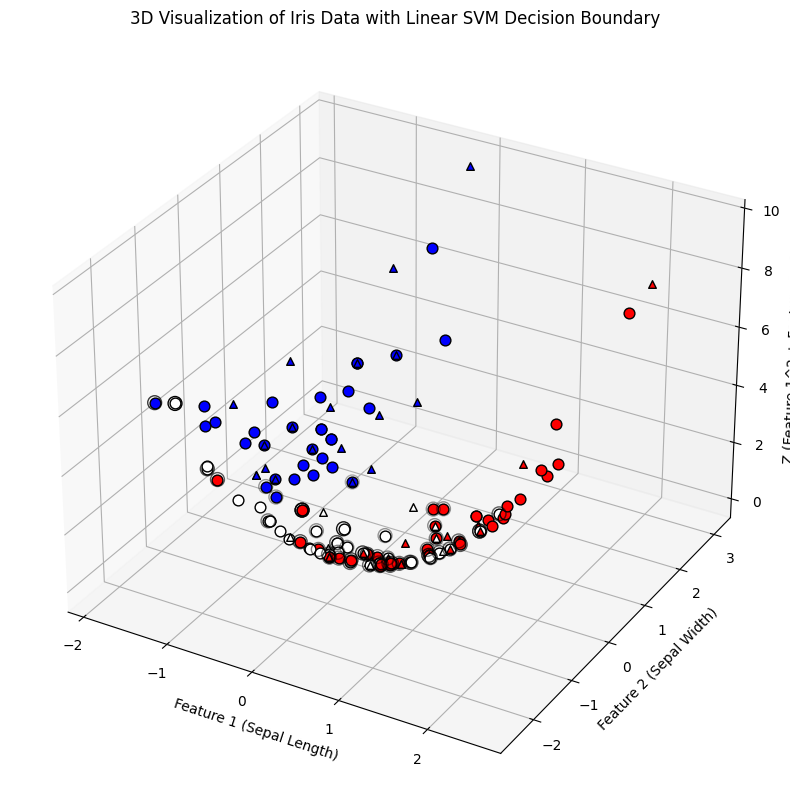

In [ ]:

# 붓꽃 데이터 로드
iris = datasets.load_iris()
X = iris.data[:, :2]  # 처음 두 특성만 사용 (Sepal Length, Sepal Width)
y = iris.target

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 고차원 변환: Z = X1^2 + X2^2
Z1_train = X_train[:, 0]
Z2_train = X_train[:, 1]
Z3_train = Z1_train**2 + Z2_train**2  # 비선형 특성 추가

Z1_test = X_test[:, 0]
Z2_test = X_test[:, 1]
Z3_test = Z1_test**2 + Z2_test**2  # 비선형 특성 추가

# 선형 SVM 모델 정의 (고차원 데이터에 적용)
svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(np.c_[Z1_train, Z2_train, Z3_train], y_train)  # 변환된 고차원 데이터로 훈련

# 3D 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 훈련 데이터 시각화
colors = {0: 'blue', 1: 'white', 2: 'red'}
for i in range(len(Z1_train)):
    ax.scatter(Z1_train[i], Z2_train[i], Z3_train[i], color=colors[y_train[i]], s=60, edgecolor='k')

# 테스트 데이터 시각화 (크기를 줄여서 표시)
for i in range(len(Z1_test)):
    ax.scatter(Z1_test[i], Z2_test[i], Z3_test[i], color=colors[y_test[i]], s=30, edgecolor='k', marker='^')

# 서포트 벡터 강조
ax.scatter(svm_linear.support_vectors_[:, 0], svm_linear.support_vectors_[:, 1],
           svm_linear.support_vectors_[:, 0]**2 + svm_linear.support_vectors_[:, 1]**2,
           s=100, facecolors='none', edgecolors='k')

# 축 설정
ax.set_xlabel('Feature 1 (Sepal Length)')
ax.set_ylabel('Feature 2 (Sepal Width)')
ax.set_zlabel('Z (Feature 1^2 + Feature 2^2)')
ax.set_title("3D Visualization of Iris Data with Linear SVM Decision Boundary")

plt.show()


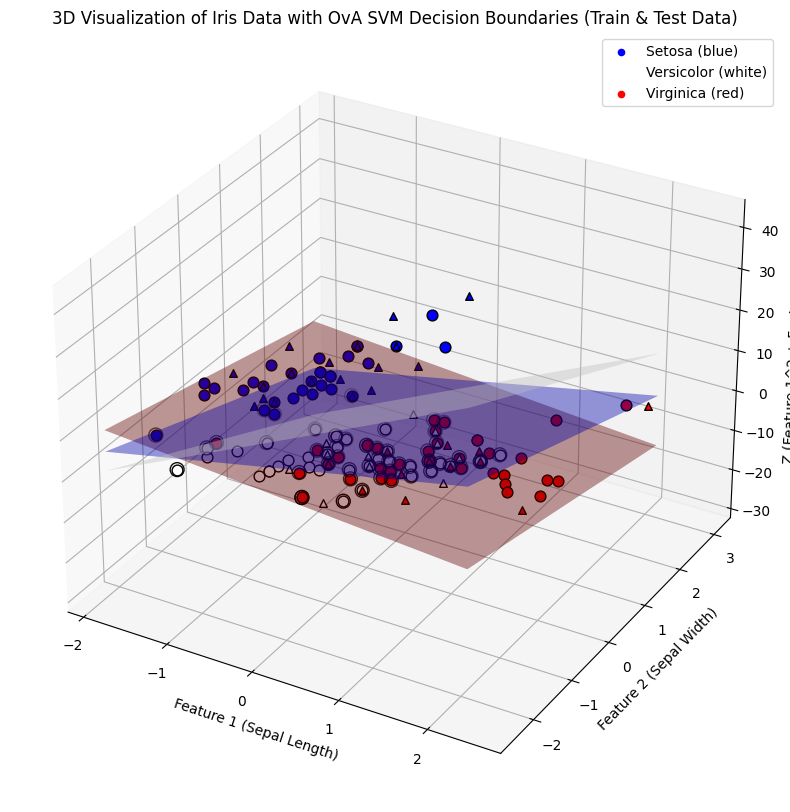

In [ ]:
# One-vs-All SVM 모델 정의 (선형 커널 사용)
svm_ova = SVC(kernel='linear', C=1, decision_function_shape='ovr') #
svm_ova.fit(np.c_[Z1_train, Z2_train, Z3_train], y_train)  # 고차원 변환된 데이터를 사용하여 훈련

# 3D 시각화 설정
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 클래스별 색상 및 꽃 이름 정의
colors = {0: 'blue', 1: 'white', 2: 'red'}
class_names = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}

# 훈련 데이터 시각화
for i in range(len(Z1_train)):
    ax.scatter(Z1_train[i], Z2_train[i], Z3_train[i], color=colors[y_train[i]], s=60, edgecolor='k')

# 테스트 데이터 시각화 (작은 크기로 표시)
for i in range(len(Z1_test)):
    ax.scatter(Z1_test[i], Z2_test[i], Z3_test[i], color=colors[y_test[i]], s=30, edgecolor='k', marker='^')

# 메쉬 그리드 생성
xx, yy = np.meshgrid(np.linspace(Z1_train.min(), Z1_train.max(), 50),
                     np.linspace(Z2_train.min(), Z2_train.max(), 50))

# 각 클래스에 대한 결정 경계 그리기
for i in range(3):  # 클래스가 3개일 때
    # 결정 경계 계산 (i번째 클래스 vs 나머지)
    zz = -(svm_ova.coef_[i, 0] * xx + svm_ova.coef_[i, 1] * yy + svm_ova.intercept_[i]) / svm_ova.coef_[i, 2]

    # 각 클래스에 대한 경계면을 해당 클래스 색상으로 그리기
    ax.plot_surface(xx, yy, zz, alpha=0.4, color=colors[i], rstride=100, cstride=100)

# 서포트 벡터 강조
ax.scatter(svm_ova.support_vectors_[:, 0], svm_ova.support_vectors_[:, 1],
           svm_ova.support_vectors_[:, 0]**2 + svm_ova.support_vectors_[:, 1]**2,
           s=100, facecolors='none', edgecolors='k')

# 범례 추가
for class_label, color in colors.items():
    ax.scatter([], [], color=color, label=f'{class_names[class_label]} ({color})')

ax.legend()

# 축 설정
ax.set_xlabel('Feature 1 (Sepal Length)')
ax.set_ylabel('Feature 2 (Sepal Width)')
ax.set_zlabel('Z (Feature 1^2 + Feature 2^2)')
ax.set_title("3D Visualization of Iris Data with OvA SVM Decision Boundaries (Train & Test Data)")

plt.show()


In [ ]:
# 테스트 데이터에 대한 예측
y_pred = svm_ova.predict(np.c_[Z1_test, Z2_test, Z3_test])

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)

# 예측 결과와 실제 값을 열로 나란히 출력
print("Actual vs Predicted Labels:")
print("Actual\tPredicted")
for actual, predicted in zip(y_test, y_pred):
    print(f"{actual}\t{predicted}")

# 정확도 출력
print(f"\nAccuracy score: {accuracy:.2f}")


Actual vs Predicted Labels:
Actual	Predicted
1	1
0	0
2	2
1	1
1	2
0	0
1	1
2	2
1	1
1	1
2	2
0	0
0	0
0	0
0	0
1	2
2	2
1	1
1	1
2	1
0	0
2	1
0	0
2	1
2	2
2	2
2	1
2	2
0	0
0	0
0	0
0	0
1	2
0	0
0	0
2	1
1	2
0	0
0	0
0	0
2	1
1	2
1	2
0	0
0	0

Accuracy score: 0.73


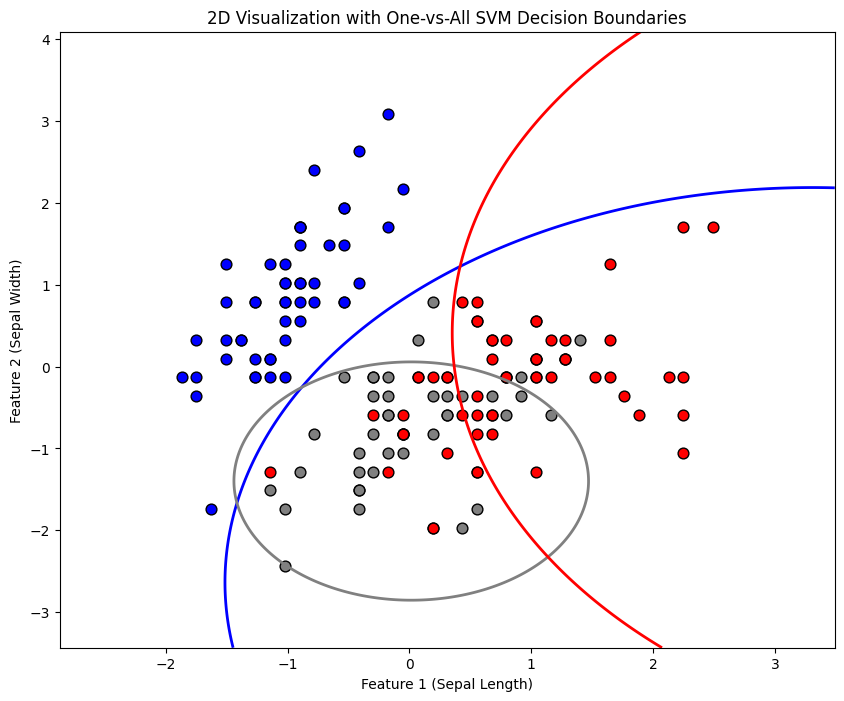

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# 붓꽃 데이터 로드
iris = datasets.load_iris()
X = iris.data[:, :2]  # 처음 두 특성만 사용 (Sepal Length, Sepal Width)
y = iris.target

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 고차원 변환: Z = X1^2 + X2^2
Z1 = X_scaled[:, 0]
Z2 = X_scaled[:, 1]
Z3 = Z1**2 + Z2**2  # 비선형 특성 추가

# 2D 시각화를 위한 One-vs-All SVM 모델을 각각의 클래스에 대해 훈련
xx, yy = np.meshgrid(np.linspace(X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1, 500),
                     np.linspace(X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1, 500))

# 시각화를 위한 준비
fig, ax = plt.subplots(figsize=(10, 8))



colors = {0: 'blue', 1: 'grey', 2: 'red'}
for i in range(len(X_scaled)):
    plt.scatter(X_scaled[i, 0], X_scaled[i, 1], color=colors[y[i]], s=60, edgecolor='k')

# 각 클래스를 기준으로 One-vs-All 모델 훈련 및 결정 경계 그리기
for i in range(3):
    # 각 클래스를 기준으로 One-vs-All 타겟 설정
    y_one_vs_all = np.where(y == i, 1, 0)

    # 선형 SVM 모델 정의
    svm_ova = SVC(kernel='linear', C=1)
    svm_ova.fit(np.c_[Z1, Z2, Z3], y_one_vs_all)

    # 2D 공간에서 결정 함수 계산
    Z = svm_ova.decision_function(np.c_[xx.ravel(), yy.ravel(), (xx.ravel() ** 2 + yy.ravel() ** 2)])
    Z = Z.reshape(xx.shape)

    # 결정 경계 그리기
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors=colors[i])

# 축 및 제목 설정
plt.xlabel('Feature 1 (Sepal Length)')
plt.ylabel('Feature 2 (Sepal Width)')
plt.title('2D Visualization with One-vs-All SVM Decision Boundaries')
plt.show()


